In [5]:
# STEP 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 2: Loading the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test['Id']

# Adding flag before merging
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['SalePrice'] = np.nan

# Merge train and test
data = pd.concat([train, test], axis=0)

# STEP 3: Handle missing value
cat_cols = data.select_dtypes(include='object').columns
data[cat_cols] = data[cat_cols].fillna("None")

# Fill numeric nulls with median
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# STEP 4: Feature engineering
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['TotalBathrooms'] = (data['FullBath'] + 0.5 * data['HalfBath'] +
                           data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath'])
data['HasGarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# STEP 5: Drop ID column
data.drop(['Id'], axis=1, inplace=True)

# STEP 6: Encoding categorical variables
data = pd.get_dummies(data)
if 'TrainFlag' not in data.columns:
    raise Exception("TrainFlag got dropped during processing!")

# STEP 7: Separate train and test again
train_data = data[data['TrainFlag'] == 1].copy()
test_data = data[data['TrainFlag'] == 0].copy()

X = train_data.drop(['SalePrice', 'TrainFlag'], axis=1)
y = train_data['SalePrice']
test_final = test_data.drop(['SalePrice', 'TrainFlag'], axis=1)

# STEP 8: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_final)

# STEP 9: Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# STEP 10: Train a model
model = LinearRegression()
model.fit(X_train, y_train)

# STEP 11: Evaluate
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.2f}")

# STEP 12: Predict and Save Submission
predictions = model.predict(test_scaled)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})
submission.to_csv("submission.csv", index=False)
print("submission.csv is ready!")


Validation RMSE: 65363.44
submission.csv is ready!


Exploratory Data Analysis (EDA) – Visual Insights

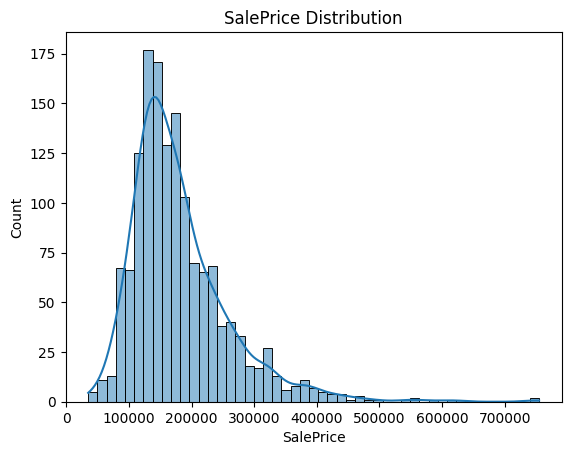

In [6]:
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()


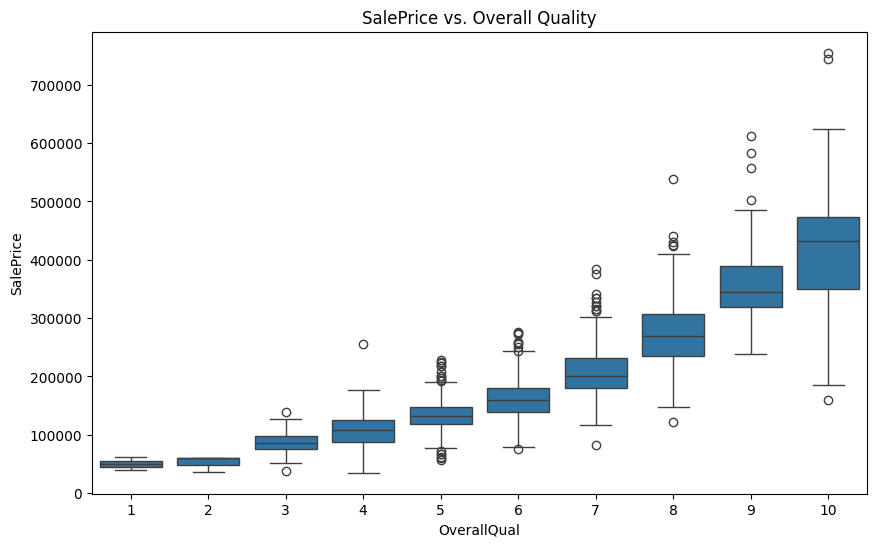

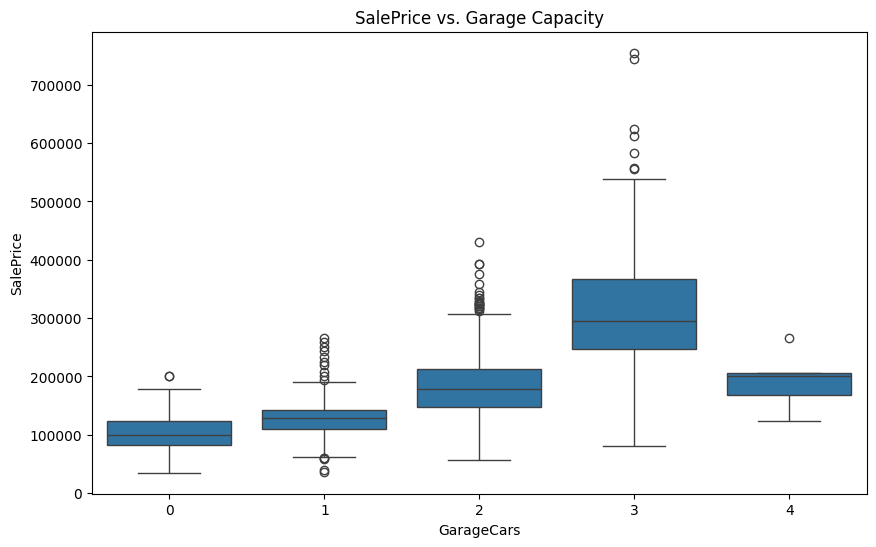

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train)
plt.title("SalePrice vs. Overall Quality")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train)
plt.title("SalePrice vs. Garage Capacity")
plt.show()


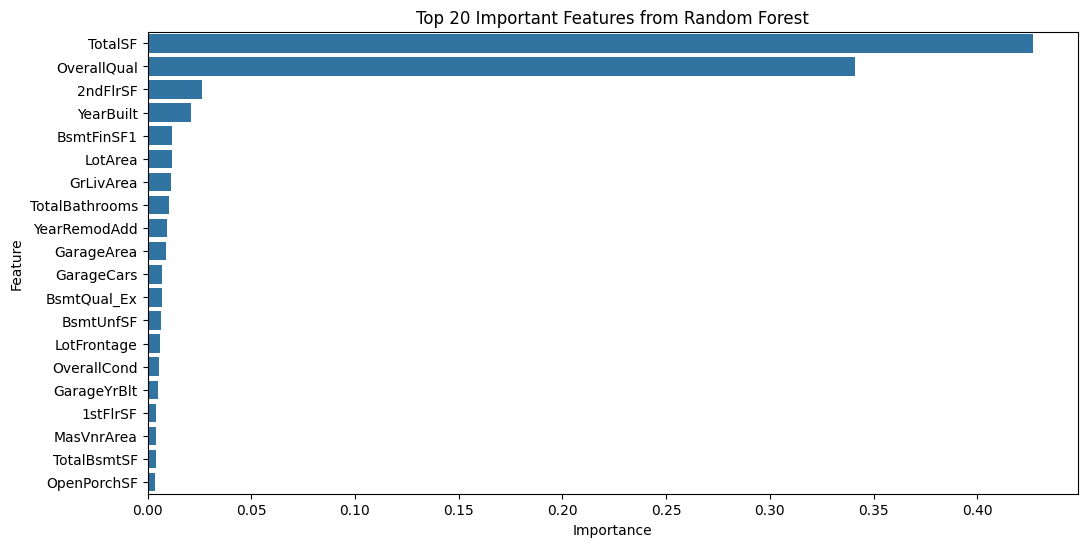

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Feature importance
importances = rf.feature_importances_
features = X.columns

# Top 20 important features
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Top 20 Important Features from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
